In [5]:
%matplotlib inline 

#Arrays 
import numpy as np
import pandas as pd

#For image handling
from scipy.misc import imresize
from imageio import imread, imsave
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

#For loading files from directories and splitting data 
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

#Keras for deep learning 
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint  
from keras import applications

# 1. Read Data Paths & Explore

In [6]:
file_paths = load_files('raw-files/data', load_content=False)
paths_df = pd.DataFrame({'Path':file_paths['filenames'], 'Label':file_paths['target']})

In [7]:
print ('Total number of images:', len(paths_df['Label']))
for i,v in enumerate(['Door', 'Sign', 'Stairs']):
    print ('Total number of %s images: %i'%(v, (paths_df['Label']==i).sum()))

Total number of images: 6166
Total number of Door images: 2262
Total number of Sign images: 2106
Total number of Stairs images: 1798


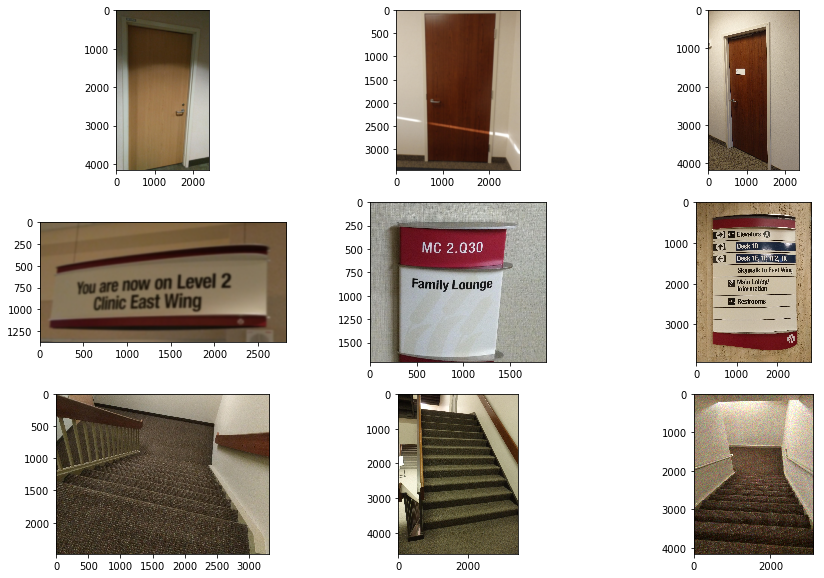

In [4]:
#Sample images randomly from each category 
fig, axs = plt.subplots(3,3, figsize=(15,10))
for i, row in enumerate(axs):
    paths = paths_df[paths_df['Label']==i]['Path']
    for ax in row:
        img = plt.imread(np.random.choice(paths))
        ax.imshow(img)
plt.show()

Image sizes are large which means the dataset as is cannot be loaded to the memory. Also, different images have different sizes. In the next section, we will attempt to standardize all images to 256,256 size. 

Intra-class and image angle variations are significant, and this may lead to challenges in achieving good accuracy. 

# 2. Resize Images 
Please refer to `resize_images.py`. The script was used to resize all images to 252,252,3 & then to 299, 299, 3

# 3. Preprocessing Data

In [5]:
#Read resized images paths 
temp = load_files('resized-data', load_content=False, categories=['Doors','Stairs','Sign'])

#Split to training, validation, and testing 
X = temp['filenames']
y = np.array(temp['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_vald, y_train, y_vald = train_test_split(X_train, y_train, test_size=0.1)

#Convert labels dummy variables 
y_train = np_utils.to_categorical(y_train)
y_vald = np_utils.to_categorical(y_vald)
y_test = np_utils.to_categorical(y_test)

In [8]:
def path_to_tensor(img_path):
    img = imread(img_path)
    img = imresize(img, (256,256,3))
    return np.expand_dims(img, axis=0)

def paths_to_tensors(paths):
    """
    Input: collection of image paths of length nb 
    Outputs: (nb, 256, 256, 3) normalized tensor 
    """
    return (np.vstack([path_to_tensor(img_path) for img_path in paths])).astype('float32')/255

In [8]:
#Get tensors from image paths 
X_train_tensors = paths_to_tensors(X_train)
X_test_tensors = paths_to_tensors(X_test)
X_vald_tensors = paths_to_tensors(X_vald)

/home/alrasheed/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


In [9]:
#Sanity check 
X_train_tensors.shape

(4993, 256, 256, 3)

# 4. Model From Scratch

In [27]:
### Defining CNN architecture
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=2, strides=1, padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
#model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 256, 256, 8)       104       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 128, 128, 16)      528       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
__________

In [28]:
#Compiling the model & setting parameters 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

In [21]:
#Checkpointer for saving best model weights 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

#Training process w/ validation 
model.fit(X_train_tensors, y_train, 
          validation_data=(X_vald_tensors, y_vald),
          epochs=3, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 4993 samples, validate on 555 samples
Epoch 1/3
4993/4993 [==============================] - 70s 14ms/step - loss: 0.4469 - acc: 0.8394 - categorical_accuracy: 0.8394 - val_loss: 0.1514 - val_acc: 0.9604 - val_categorical_accuracy: 0.9604

Epoch 00001: val_loss improved from inf to 0.15143, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/3
4993/4993 [==============================] - 69s 14ms/step - loss: 0.0855 - acc: 0.9716 - categorical_accuracy: 0.9716 - val_loss: 0.0463 - val_acc: 0.9838 - val_categorical_accuracy: 0.9838

Epoch 00002: val_loss improved from 0.15143 to 0.04630, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/3
4993/4993 [==============================] - 69s 14ms/step - loss: 0.0384 - acc: 0.9874 - categorical_accuracy: 0.9874 - val_loss: 0.0227 - val_acc: 0.9982 - val_categorical_accuracy: 0.9982

Epoch 00003: val_loss improved from 0.04630 to 0.02272, saving model to saved_models/weights.best.from_scratch.hdf5


In [29]:
#Loading best weights 
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [14]:
#loss / acc / cat_acc
model.evaluate(X_test_tensors, y_test)

617/617 [==============================] - 3s 5ms/step


[0.008843396805514351, 0.9983792544570502, 0.9983792544570502]

In [24]:
## Check score manually 

#Get predictions 
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in X_test_tensors]

#Evaluate Accuracy  
test_accuracy = (predictions == np.argmax(y_test,axis=1)).sum()/len(y_test)
print('Test accuracy: %.4f%%' % (test_accuracy*100))

Test accuracy: 99.3517%


## 4.1 Wrapping Model

In [40]:
class  ndoor_eye(object):
    predMap = {0:'Door', 1:'Sign', 2:'Stairs'}
    
    def __init__(self, img_path):
        assert type(img_path) == str 
        self.img_path = img_path
        self.img = None
        self.pred = None
    
    def _updateImg(self):
        self.img = imresize(imread(self.img_path), (256,256,3))
        
    def _updateKind(self):
        if not self.img:
            self._updateImg()
        tensor = np.expand_dims(self.img, axis=0).astype('float32')/255
        self.pred = np.argmax(model.predict(tensor))
        
    def display(self):
        imshow(self.img)
        plt.show()
    
    def detect(self):
        print ('\n\nDetecting ...')
        self._updateKind()
        print ('%s detected ahead of you!'%(self.predMap[self.pred]))
        self.display()

In [9]:
#Test on external images 
paths = ['door1', 'door2', 'sign1', 'sign2', 'sign3', 'stairs1', 'stairs2', 'stairs3']
paths = ['external-test/'+path+'.jpg' for path in paths]



Detecting ...
Door detected ahead of you!


/home/alrasheed/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


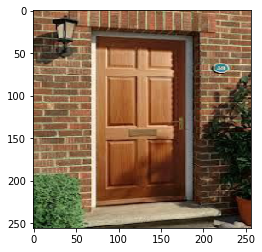



Detecting ...
Door detected ahead of you!


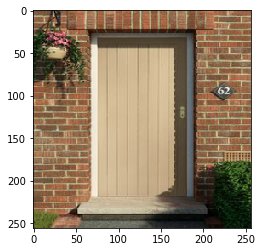



Detecting ...
Sign detected ahead of you!


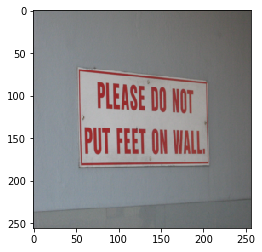



Detecting ...
Sign detected ahead of you!


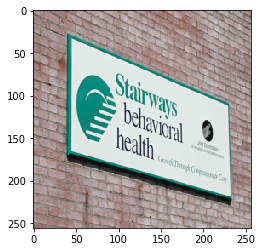



Detecting ...
Stairs detected ahead of you!


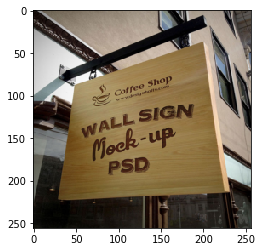



Detecting ...
Sign detected ahead of you!


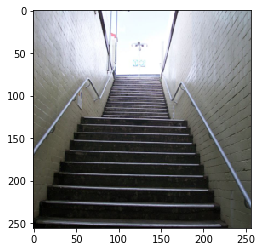



Detecting ...
Sign detected ahead of you!


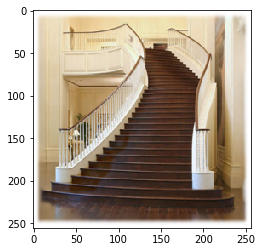



Detecting ...
Door detected ahead of you!


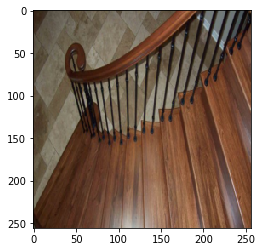

In [44]:
for path in paths: 
    ndoor_eye(path).detect()

Even though the model scored high accuracy, however, it is failing to accurately detect images from outsides the corpus. This indicates overfitting, which is expected such relatively small dataset. To address this, transfer learning will be used. 

# 5. Transfer Learning

In [46]:
inception = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')

#Freeze existing layers
for layer in inception.layers:
    layer.trainable = False

In [47]:
inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_101[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_102

In [48]:
x = inception.output
x = GlobalAveragePooling2D()(x)
pred = Dense(3, activation='softmax')(x)

model = Model(inputs=inception.input, outputs = pred)

#Get inception with weights trained on ImageNet dataset
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception1.hdf5', 
#                                verbose=1, save_best_only=True)

# model.fit(X_train_tensors, y_train, 
#           validation_data=(X_vald_tensors, y_vald),
#           epochs=3, batch_size=20, callbacks=[checkpointer], verbose=1)

In [49]:
model.load_weights('saved_models/weights.best.inception1.hdf5')

In [12]:
## Check score manually 

#Get predictions 
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in X_test_tensors]

#Evaluate Accuracy  
test_accuracy = (predictions == np.argmax(y_test,axis=1)).sum()/len(y_test)
print('Test accuracy: %.4f%%' % (test_accuracy*100))

Test accuracy: 98.0551%


In [19]:
#loss / acc / cat_acc
model.evaluate(X_test_tensors, y_test)

617/617 [==============================] - 90s 146ms/step


[0.05684064658746618, 0.9870340356564019, 0.9870340356564019]



Detecting ...


/home/alrasheed/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Door detected ahead of you!


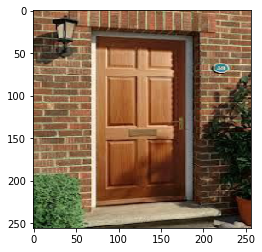



Detecting ...
Door detected ahead of you!


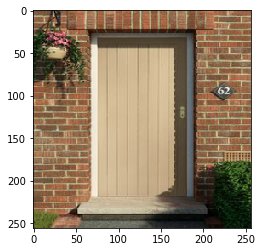



Detecting ...
Sign detected ahead of you!


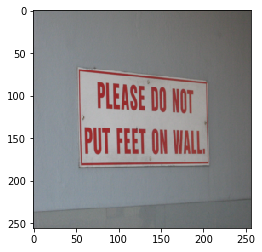



Detecting ...
Sign detected ahead of you!


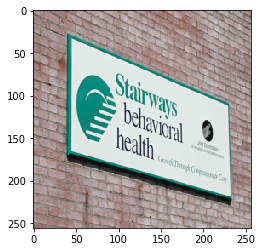



Detecting ...
Sign detected ahead of you!


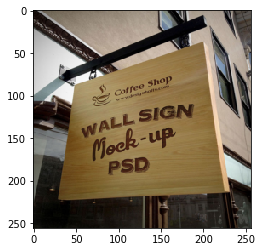



Detecting ...
Stairs detected ahead of you!


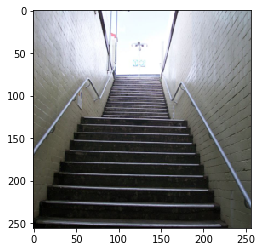



Detecting ...
Stairs detected ahead of you!


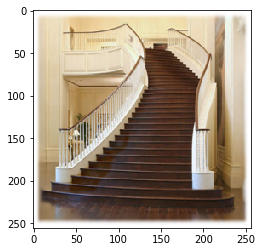



Detecting ...
Stairs detected ahead of you!


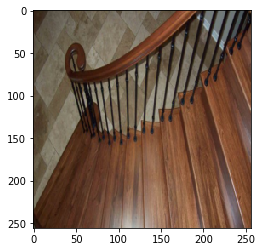

In [50]:
for path in paths: 
    ndoor_eye(path).detect()

The accuracy is lower than the previous model, however, based on the modest external image testing, the model appears to have generalized very well! 

# Tidying Up Code for Production 
Also this code can be used by grader for testing out the model 

In [10]:

print ('Loading the model ...')

%matplotlib inline
from keras.layers import GlobalAveragePooling2D
from keras.layers import  Dense
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras import applications
from keras.models import Model
from imageio import imread
from scipy.misc import imresize

#Get inception with weights trained on ImageNet dataset
inception = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')

#Freeze existing layers
for layer in inception.layers:
    layer.trainable = False

#Add Classifications Layers, then load weights from pre-trained model 
x = inception.output
x = GlobalAveragePooling2D()(x)
pred = Dense(3, activation='softmax')(x)
model = Model(inputs=inception.input, outputs = pred)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
model.load_weights('saved_models/weights.best.inception1.hdf5')


#create class for interaction with model 
class  ndoor_eye(object):
    predMap = {0:'Door', 1:'Sign', 2:'Stairs'}
    
    def __init__(self, img_path):
        assert type(img_path) == str 
        self.img_path = img_path
        self.img = None
        self.pred = None
    
    def _updateImg(self):
        self.img = imresize(imread(self.img_path), (256,256,3))
        
    def _updateKind(self):
        if not self.img:
            self._updateImg()
        tensor = np.expand_dims(self.img, axis=0).astype('float32')/255
        self.pred = np.argmax(model.predict(tensor))
        
    def display(self):
        imshow(self.img)
        plt.show()
    
    def detect(self):
        print ('\n\nDetecting ...')
        self._updateKind()
        print ('%s detected ahead of you!'%(self.predMap[self.pred]))
        self.display()
        
## To be continued after the NanoDegree. Creating an API and web interface using Flask

Loading the model ...




Detecting ...


/home/alrasheed/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Door detected ahead of you!


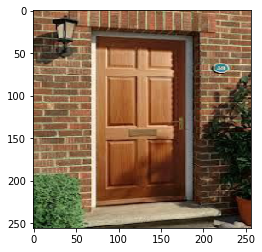



Detecting ...
Door detected ahead of you!


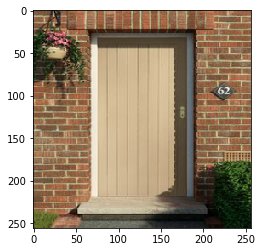



Detecting ...
Sign detected ahead of you!


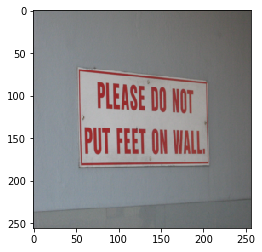



Detecting ...
Sign detected ahead of you!


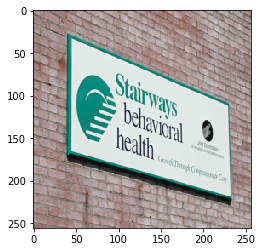



Detecting ...
Sign detected ahead of you!


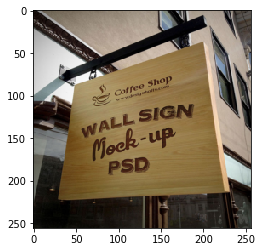



Detecting ...
Stairs detected ahead of you!


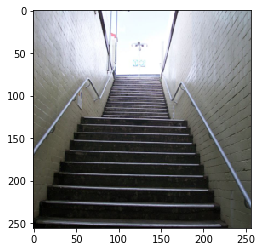



Detecting ...
Stairs detected ahead of you!


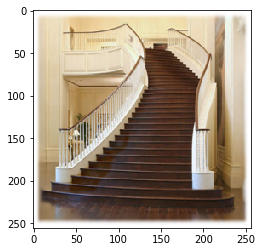



Detecting ...
Stairs detected ahead of you!


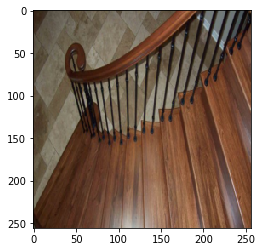

In [11]:
for path in paths: 
    ndoor_eye(path).detect()